In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

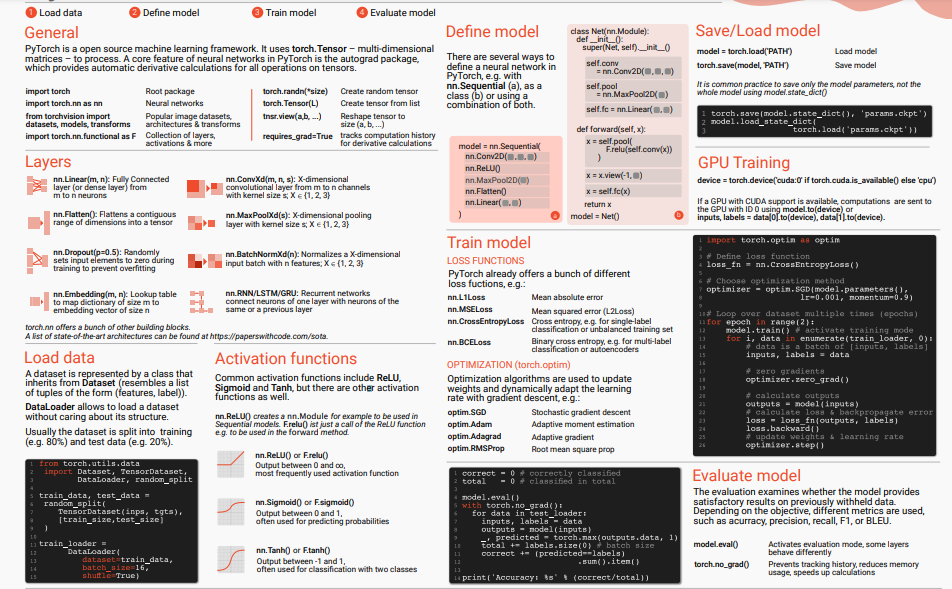

In [5]:
print([i for i in list(dir(torch.optim)) if '_' not in i])

['ASGD', 'Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'LBFGS', 'NAdam', 'Optimizer', 'RAdam', 'RMSprop', 'Rprop', 'SGD', 'SparseAdam']


dir(torch.nn)

    ['AdaptiveAvgPool1d', 'AdaptiveAvgPool2d', 'AdaptiveAvgPool3d', 'AdaptiveLogSoftmaxWithLoss', 'AdaptiveMaxPool1d', 'AdaptiveMaxPool2d', 'AdaptiveMaxPool3d', 'AlphaDropout', 'AvgPool1d', 'AvgPool2d', 'AvgPool3d', 'BCELoss', 'BCEWithLogitsLoss', 'BatchNorm1d', 'BatchNorm2d', 'BatchNorm3d', 'Bilinear', 'CELU', 'CTCLoss', 'ChannelShuffle', 'ConstantPad1d', 'ConstantPad2d', 'ConstantPad3d', 'Container', 'Conv1d', 'Conv2d', 'Conv3d', 'ConvTranspose1d', 'ConvTranspose2d', 'ConvTranspose3d', 'CosineEmbeddingLoss', 'CosineSimilarity', 'CrossEntropyLoss', 'CrossMapLRN2d', 'DataParallel', 'Dropout', 'Dropout1d', 'Dropout2d', 'Dropout3d', 'ELU', 'Embedding', 'EmbeddingBag', 'FeatureAlphaDropout', 'Flatten', 'Fold', 'FractionalMaxPool2d', 'FractionalMaxPool3d', 'GELU', 'GLU', 'GRU', 'GRUCell', 'GaussianNLLLoss', 'GroupNorm', 'Hardshrink', 'Hardsigmoid', 'Hardswish', 'Hardtanh', 'HingeEmbeddingLoss', 'HuberLoss', 'Identity', 'InstanceNorm1d', 'InstanceNorm2d', 'InstanceNorm3d', 'KLDivLoss', 'L1Loss', 'LPPool1d', 'LPPool2d', 'LSTM', 'LSTMCell', 'LayerNorm', 'LazyBatchNorm1d', 'LazyBatchNorm2d', 'LazyBatchNorm3d', 'LazyConv1d', 'LazyConv2d', 'LazyConv3d', 'LazyConvTranspose1d', 'LazyConvTranspose2d', 'LazyConvTranspose3d', 'LazyInstanceNorm1d', 'LazyInstanceNorm2d', 'LazyInstanceNorm3d', 'LazyLinear', 'LeakyReLU', 'Linear', 'LocalResponseNorm', 'LogSigmoid', 'LogSoftmax', 'MSELoss', 'MarginRankingLoss', 'MaxPool1d', 'MaxPool2d', 'MaxPool3d', 'MaxUnpool1d', 'MaxUnpool2d', 'MaxUnpool3d', 'Mish', 'Module', 'ModuleDict', 'ModuleList', 'MultiLabelMarginLoss', 'MultiLabelSoftMarginLoss', 'MultiMarginLoss', 'MultiheadAttention', 'NLLLoss', 'NLLLoss2d', 'PReLU', 'PairwiseDistance', 'Parameter', 'ParameterDict', 'ParameterList', 'PixelShuffle', 'PixelUnshuffle', 'PoissonNLLLoss', 'RNN', 'RNNBase', 'RNNCell', 'RNNCellBase', 'RReLU', 'ReLU', 'ReLU6', 'ReflectionPad1d', 'ReflectionPad2d', 'ReflectionPad3d', 'ReplicationPad1d', 'ReplicationPad2d', 'ReplicationPad3d', 'SELU', 'Sequential', 'SiLU', 'Sigmoid', 'SmoothL1Loss', 'SoftMarginLoss', 'Softmax', 'Softmax2d', 'Softmin', 'Softplus', 'Softshrink', 'Softsign', 'SyncBatchNorm', 'Tanh', 'Tanhshrink', 'Threshold', 'Transformer', 'TransformerDecoder', 'TransformerDecoderLayer', 'TransformerEncoder', 'TransformerEncoderLayer', 'TripletMarginLoss', 'TripletMarginWithDistanceLoss', 'Unflatten', 'Unfold', 'UninitializedBuffer', 'UninitializedParameter', 'Upsample', 'UpsamplingBilinear2d', 'UpsamplingNearest2d', 'ZeroPad2d', 'functional', 'grad', 'init', 'intrinsic', 'modules', 'parallel', 'parameter', 'qat', 'quantizable', 'quantized', 'utils']

In [34]:
def make_batch():
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()  # space tokenizer
        input = [word_dict[n] for n in word[:-1]]  # create (1~n-1) as input
        target = word_dict[word[-1]]  # create (n) as target, We usually call this 'casual language model'

        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)

    return np.array(input_batch), np.array(target_batch)

In [38]:
class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden)
        self.W = nn.Linear(n_hidden, n_class, bias=False)
        self.b = nn.Parameter(torch.ones([n_class]))

    def forward(self, hidden, X):
        X = X.transpose(0, 1) # X : [n_step, batch_size, n_class]
        outputs, hidden = self.rnn(X, hidden)
        # outputs : [n_step, batch_size, num_directions(=1) * n_hidden]
        # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        outputs = outputs[-1] # [batch_size, num_directions(=1) * n_hidden]
        model = self.W(outputs) + self.b # model : [batch_size, n_class]
        return model

In [36]:
n_step = 2 # number of cells(= number of Step)
n_hidden = 5 # number of hidden units in one cell

sentences = ["i like dog", "i love coffee", "i hate milk"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)
batch_size = len(sentences)

model = TextRNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_batch, target_batch = make_batch()
input_batch = torch.FloatTensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [37]:
# Training
for epoch in range(3000):
    optimizer.zero_grad()

    # hidden : [num_layers * num_directions, batch, hidden_size]
    hidden = torch.zeros(1, batch_size, n_hidden)
    # input_batch : [batch_size, n_step, n_class]
    output = model(hidden, input_batch)

    # output : [batch_size, n_class], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

NotImplementedError: Module [TextRNN] is missing the required "forward" function

In [ ]:
input = [sen.split()[:2] for sen in sentences]

# Predict
hidden = torch.zeros(1, batch_size, n_hidden)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]

print(predict)
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])